In [1]:
import os
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import scipy
import cv2
import xarray as xr
import numpy as np
import rioxarray as rxr

from pathlib import Path

In [2]:
data_dir = Path(os.path.dirname(os.path.abspath("__file__"))).parent.joinpath('data')

# Dataset for ground water model (concentrations)
# Dataset ds is ordered with (z,y,x) coordinates
ds = xr.open_dataset(data_dir.joinpath('concentratie_data_gw_model.nc'))
# Replace negative concentrations (due to model errors) with 0
ds = ds.where((ds.conc >= 0) | ds.isnull(), other = 0)

# Dataset of bathymetry
ds_b0 = rxr.open_rasterio(data_dir.joinpath('originele_bodem.tif'))

# Read satellite image with surrounding sea
sat = mpimg.imread(data_dir.joinpath('terschelling-sat2.png'))

# Dataset for wadsea water level  (not in github due to size, can be found at p:\1204421-kpp-benokust\2020\4-Zeegaten\03_systeemsuppleties\basis_model\fm\DFM_OUTPUT_wadsea\)
ds_wl = xr.open_dataset(data_dir.joinpath('wadsea_0000_map.nc'))

In [3]:
extent = ds.x.values.min(), ds.x.values.max(), ds.y.values.min(), ds.y.values.max()

# Grid for chosen area of Terschelling (for the bathymetry)
x_b0, y_b0 = np.array(ds_b0.x[1201:2970]), np.array(ds_b0.y[1435:2466])
X_b0, Y_b0 = np.meshgrid(ds_b0.x[1201:2969], ds_b0.y[1435:2466])
bodem0 = np.array(ds_b0[0,1435:2466,1201:2970])
bodem0[np.where(bodem0 == -9999)] = -43.8

# Obtain gridpoints from waterlevel model output which are within the bounds
x_grid, y_grid = ds_wl.mesh2d_face_x, ds_wl.mesh2d_face_y
terschelling_area = []
for i in range(x_grid.size):
    if x_grid[i] >= extent[0] and x_grid[i] <= extent[1] and y_grid[i] >= extent[2] and y_grid[i] <= extent[3]:
        terschelling_area.append(i)

# Lightsource for shadow in bathymetry dataset
ls = LightSource(azdeg=315, altdeg=45)

In [4]:
# Create shade using lightsource
rgb = ls.hillshade(bodem0,
               vert_exag=5, dx=20, dy=20)
# Scale satellite image to bathymetry shapes
sat_scaled = cv2.resize(sat, dsize=(bodem0.shape[1], bodem0.shape[0]), interpolation=cv2.INTER_CUBIC)
sat_scaled = sat_scaled.astype('float64')

# Add shade to scaled image
img_shade = ls.shade_rgb(sat_scaled, bodem0, vert_exag=5, blend_mode='soft')

In [5]:
# Find index for location at sea close to Terschelling
index = 0
for i in range(x_grid.size):
    if x_grid[i] <= 145000 and x_grid[i] >= 144000 and y_grid[i] <= 604000 and y_grid[i] >= 603500:
        index = i
        break
        
print('The chosen location for determining the waterlevels is at '
      f'x = {x_grid.values[i]:.0f}, y = {y_grid.values[i]:.0f} (at index = {index:.0f} in the grid)')

The chosen location for determining the waterlevels is at x = 144793, y = 603721 (at index = 23484 in the grid)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


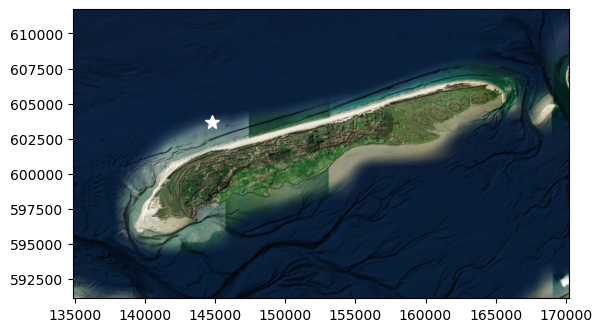

In [6]:
# Plot of chosen location near Terschelling
x_grid_t, y_grid_t = x_grid[terschelling_area], y_grid[terschelling_area]
wl_t = ds_wl.mesh2d_s1[:,terschelling_area]

fig, axes = plt.subplots()
levels = np.linspace(-3.0, 3.0, 100)
im = axes.imshow(img_shade, extent=extent)
loc = axes.plot([x_grid.values[index]], [y_grid.values[index]], marker='*', markersize=10, color='white')

# Find and plot local and global extrema
The figure below shows where the local extrema are located. With these local extrema we define an average for the high waterlevel and low waterlevel.

Note that the function used for finding these extrema might miss some extrema (as can be seen in the figure), however since we are only interested in an approximate average high waterleven and low waterlevel this does not pose a big problem.

Time step where waterlevel is approximately the avg high waterlevel: 659 (0.76m)
Time step where waterlevel is approximately the avg low waterlevel: 573 (-0.29m)
Time step where waterlevel is the max waterlevel: 114 (1.59m)
Time step where waterlevel is the min waterlevel: 400 (-1.34m)


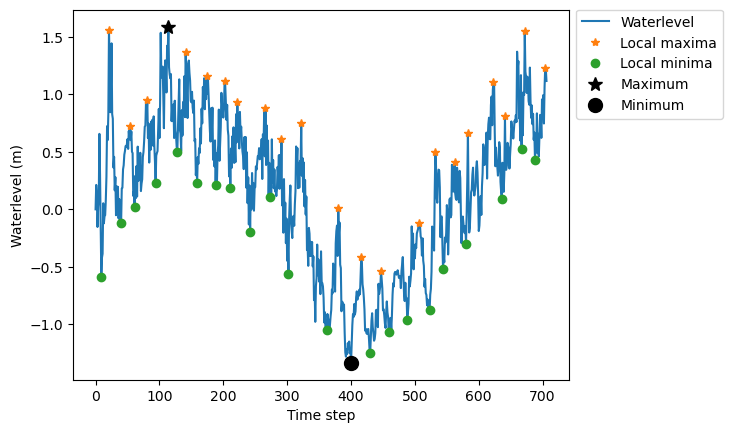

In [7]:
# Find local extrema (number of extrema depends on order)
loc_max = scipy.signal.argrelextrema(ds_wl.mesh2d_s1[:, index].values, np.greater, order=15)[0]
loc_min = scipy.signal.argrelextrema(ds_wl.mesh2d_s1[:, index].values, np.less, order=15)[0]

# Get index of global extrema
t_max_wl = np.argmax(ds_wl.mesh2d_s1.values[:,index])
t_min_wl = np.argmin(ds_wl.mesh2d_s1.values[:,index])

# Plot waterlevel as well as local and global extrema
fig, axes = plt.subplots()
axes.plot(ds_wl.mesh2d_s1[:,index])
axes.plot(loc_max, ds_wl.mesh2d_s1.values[loc_max,index], marker='*', linestyle='')
axes.plot(loc_min, ds_wl.mesh2d_s1.values[loc_min,index], marker='o', linestyle='')
axes.plot(t_max_wl, ds_wl.mesh2d_s1.values[t_max_wl,index], marker='*', linestyle='', markersize=10, color='black')
axes.plot(t_min_wl, ds_wl.mesh2d_s1.values[t_min_wl,index], marker='o', linestyle='', markersize=10, color='black')
axes.set_xlabel('Time step')
axes.set_ylabel('Waterlevel (m)')
t_hoog = np.argmax(ds_wl.mesh2d_s1.values[:,index])
t_laag = np.argmin(ds_wl.mesh2d_s1.values[:,index])
wl_hoog_avg = np.mean(ds_wl.mesh2d_s1.values[loc_max,index])
wl_laag_avg = np.mean(ds_wl.mesh2d_s1.values[loc_min,index])
axes.legend(['Waterlevel', 'Local maxima', 'Local minima', 'Maximum', 'Minimum'], bbox_to_anchor=[1,1.02])

# Find one example of a time step where the waterlevel is close to high avg and low avg respectively
for i in range(len(ds_wl.mesh2d_s1.values[:,index])):
    if abs(ds_wl.mesh2d_s1.values[i,index] - wl_hoog_avg) < 0.01:
        t_hoog_avg = i
    if abs(ds_wl.mesh2d_s1.values[i,index] - wl_laag_avg) < 0.01:
        t_laag_avg = i
        
        
print('Time step where waterlevel is approximately the avg high waterlevel: ' + str(t_hoog_avg) + f' ({ds_wl.mesh2d_s1.values[t_hoog_avg,index]:.2}m)')
print('Time step where waterlevel is approximately the avg low waterlevel: ' + str(t_laag_avg) + f' ({ds_wl.mesh2d_s1.values[t_laag_avg,index]:.2}m)')

print('Time step where waterlevel is the max waterlevel: ' + str(t_max_wl) + f' ({ds_wl.mesh2d_s1.values[t_max_wl,index]:.3}m)')
print('Time step where waterlevel is the min waterlevel: ' + str(t_min_wl) + f' ({ds_wl.mesh2d_s1.values[t_min_wl,index]:.3}m)')